In [1]:
import pandas as pd
import numpy as np

url="https://raw.githubusercontent.com/amankharwal/Website-data/master/weatherAUS.csv"
df = pd.read_csv(url)
df.head(10)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No
5,2008-12-06,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,W,19.0,24.0,55.0,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9,No,0.0,No
6,2008-12-07,Albury,14.3,25.0,0.0,NaN,NaN,W,50.0,SW,W,20.0,24.0,49.0,19.0,1009.6,1008.2,1.0,NaN,18.1,24.6,No,0.0,No
7,2008-12-08,Albury,7.7,26.7,0.0,NaN,NaN,W,35.0,SSE,W,6.0,17.0,48.0,19.0,1013.4,1010.1,NaN,NaN,16.3,25.5,No,0.0,No
8,2008-12-09,Albury,9.7,31.9,0.0,NaN,NaN,NNW,80.0,SE,NW,7.0,28.0,42.0,9.0,1008.9,1003.6,NaN,NaN,18.3,30.2,No,1.4,Yes
9,2008-12-10,Albury,13.1,30.1,1.4,NaN,NaN,W,28.0,S,SSE,15.0,11.0,58.0,27.0,1007.0,1005.7,NaN,NaN,20.1,28.2,Yes,0.0,No


In [2]:
print("Shape :{}".format(df.shape))
print("Columns :{}".format(df.columns.values))

Shape :(142193, 24)
Columns :['Date' 'Location' 'MinTemp' 'MaxTemp' 'Rainfall' 'Evaporation' 'Sunshine'
 'WindGustDir' 'WindGustSpeed' 'WindDir9am' 'WindDir3pm' 'WindSpeed9am'
 'WindSpeed3pm' 'Humidity9am' 'Humidity3pm' 'Pressure9am' 'Pressure3pm'
 'Cloud9am' 'Cloud3pm' 'Temp9am' 'Temp3pm' 'RainToday' 'RISK_MM'
 'RainTomorrow']


Look at the RainTommorrow : Thats the prediction column

Convert the RainToday and RainTommorrow (Yes/No) to 0/1

In [3]:
df['RainToday'].replace({'No':0,'Yes':1},inplace=True)
df['RainTomorrow'].replace({'No':0,'Yes':1},inplace=True)

df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0.0,0.0,0
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0.0,0.0,0
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0.0,0.0,0
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,0.0,1.0,0
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0.0,0.2,0


In [4]:
# From the table we have to drop Evaporation and Sunshine but lets look for null columns

for i in df.columns.values:
  print(i," :",sum(pd.isnull(df[i])))

Date  : 0
Location  : 0
MinTemp  : 637
MaxTemp  : 322
Rainfall  : 1406
Evaporation  : 60843
Sunshine  : 67816
WindGustDir  : 9330
WindGustSpeed  : 9270
WindDir9am  : 10013
WindDir3pm  : 3778
WindSpeed9am  : 1348
WindSpeed3pm  : 2630
Humidity9am  : 1774
Humidity3pm  : 3610
Pressure9am  : 14014
Pressure3pm  : 13981
Cloud9am  : 53657
Cloud3pm  : 57094
Temp9am  : 904
Temp3pm  : 2726
RainToday  : 1406
RISK_MM  : 0
RainTomorrow  : 0


Check if dataset is balanced or unbalanced .If the data is unbalanced, we will either downsample the majority or oversample the minority to balance it.

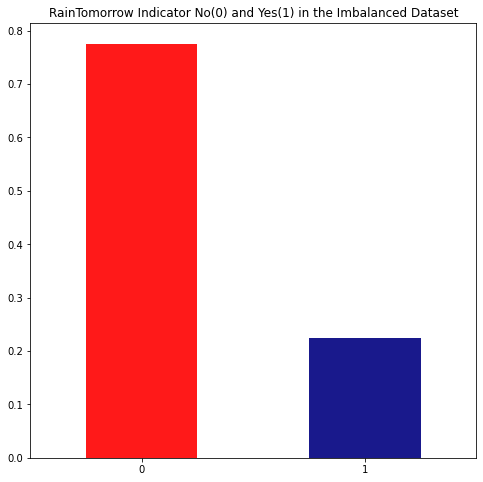

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
df.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['red','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

To fight against the class imbalance, we will use here the oversampling of the minority class.Since the size of the dataset is quite small, majority class subsampling wouldn’t make much sense here.

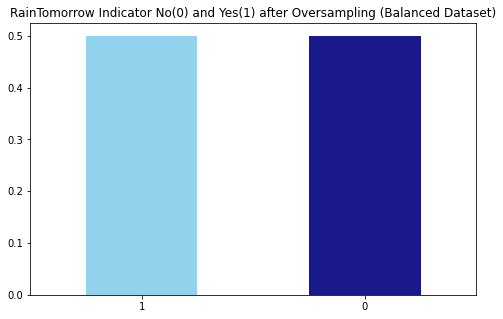

In [6]:
from sklearn.utils import resample

no = df[df.RainTomorrow ==0]
yes = df[df.RainTomorrow ==1]

yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])
fig = plt.figure(figsize = (8,5))
oversampled.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()

In the 4th code section , we have seen the number of missing data in dataset. To deal with it - We have to look for the missing data percentage 

In [7]:
# Obviously, “Evaporation”, “Sunshine”, “Cloud9am”, “Cloud3pm” are the features with a high missing percentage.

total = oversampled.isnull().sum().sort_values(ascending=False)
percent = (oversampled.isnull().sum()/oversampled.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head(4)

,Total,Percent
Sunshine,104831,0.475140
Evaporation,95411,0.432444
Cloud3pm,85614,0.388040
Cloud9am,81339,0.368664


If the above missing percent would be > 0.5 ,we would have droped the entire column but now we will consider them with imputation

# **Imputation**

In [8]:
oversampled.select_dtypes(include=['object']).columns

Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

In [9]:
# Date and Location shows zero null values
oversampled['WindGustDir'] = oversampled['WindGustDir'].fillna(oversampled['WindGustDir'].mode()[0])
oversampled['WindDir9am'] = oversampled['WindDir9am'].fillna(oversampled['WindDir9am'].mode()[0])
oversampled['WindDir3pm'] = oversampled['WindDir3pm'].fillna(oversampled['WindDir3pm'].mode()[0])

In [10]:
# Convert categorical features to continuous features with Label Encoding
from sklearn.preprocessing import LabelEncoder
lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    oversampled[col] = lencoders[col].fit_transform(oversampled[col])

In [11]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

Impute = oversampled.copy(deep =True)

Model_imputer = IterativeImputer()

Impute.iloc[: , :] = Model_imputer.fit_transform(oversampled)

/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [12]:
# Detecting outliers with IQR
Q1 = Impute.quantile(0.25)
Q3 = Impute.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Date             1535.000000
Location           25.000000
MinTemp             9.300000
MaxTemp            10.200000
Rainfall            2.400000
Evaporation         4.119679
Sunshine            5.947404
WindGustDir         9.000000
WindGustSpeed      19.000000
WindDir9am          8.000000
WindDir3pm          8.000000
WindSpeed9am       13.000000
WindSpeed3pm       11.000000
Humidity9am        26.000000
Humidity3pm        30.000000
Pressure9am         8.800000
Pressure3pm         8.800000
Cloud9am            4.000000
Cloud3pm            3.681346
Temp9am             9.300000
Temp3pm             9.800000
RainToday           1.000000
RISK_MM             5.200000
RainTomorrow        1.000000
dtype: float64


In [13]:
# Removing outliers from dataset
Impute = Impute[~((Impute < (Q1 - 1.5 * IQR)) |(Impute > (Q3 + 1.5 * IQR))).any(axis=1)]
Impute.shape

(156852, 24)

Check for multi-collinearity - If features are strongly related to each other,remove one and keep one

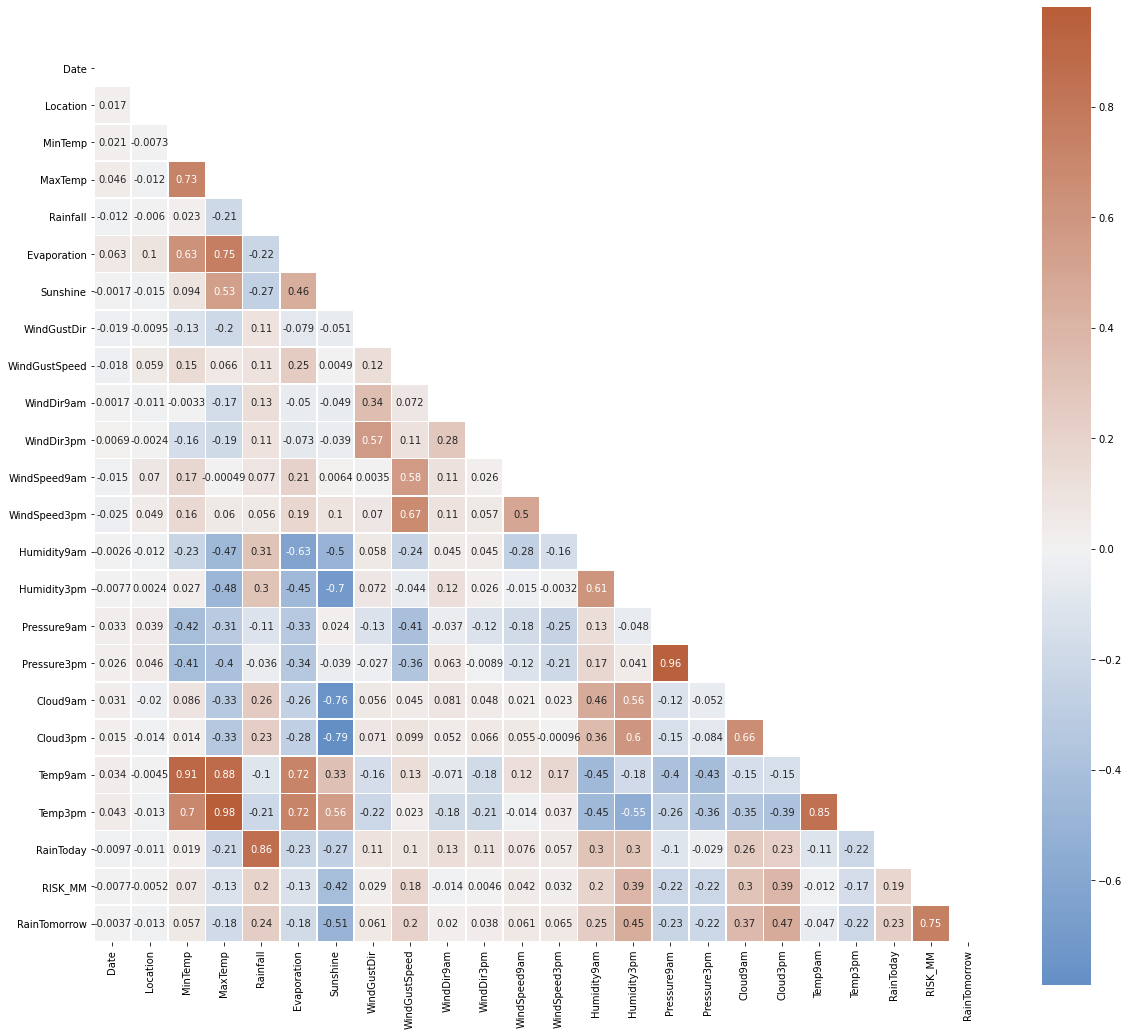

In [14]:
import seaborn as sns

corr = Impute.corr()
mask = np.triu(np.ones_like(corr,np.bool))

f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

From the heatmap ,the pairs with strong correlation :
1. MaxTemp and MinTemp :0.73
2. Pressure 3pm and Pressure9pm :0.96
3. MinTemp and Temp9am :0.91
4. Temp3pm and MaxTemp : 0.98
5. Evaporation and MaxTemp
6. Temp9pm and Temp3pm 



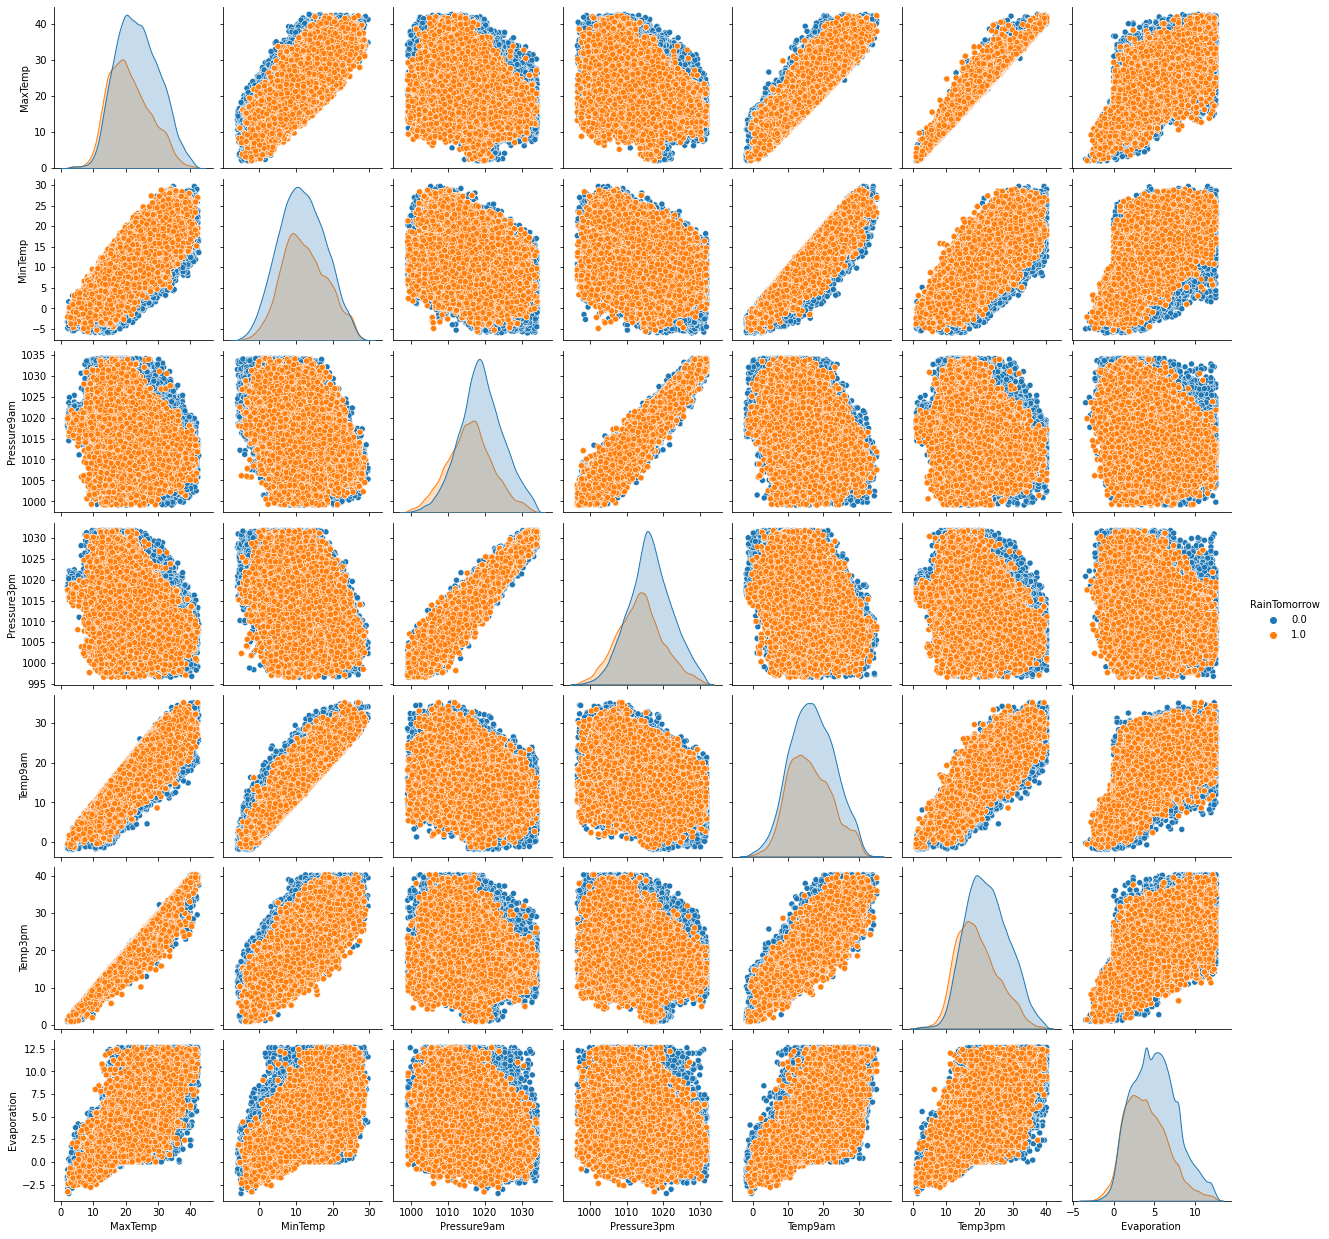

In [15]:
sns.pairplot( data=Impute, vars=('MaxTemp','MinTemp','Pressure9am','Pressure3pm', 'Temp9am', 'Temp3pm', 'Evaporation'), hue='RainTomorrow' )

## **Feature Selection for Rainfall Prediction**

In [18]:
from sklearn import preprocessing

scalar = preprocessing.MinMaxScaler()
scalar.fit(Impute)

modified_data = pd.DataFrame(scalar.transform(Impute),index=Impute.index,columns=Impute.columns)


In [22]:
# Feature Importance using Filter Method (Chi-Square)

from sklearn.feature_selection import chi2,SelectKBest

X = modified_data.drop(['RainTomorrow'],axis=1)
y = modified_data[['RainTomorrow']]
selector = SelectKBest(chi2,k=10)
selector.fit(X,y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])


Index(['Sunshine', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm',
       'Cloud9am', 'Cloud3pm', 'Temp3pm', 'RainToday', 'RISK_MM'],
      dtype='object')


**From the result above ,the most important features are :**

1. Sunshine
2. Humidity9am 
3. Humidity3pm
4. Pressure9am 
5. Pressure3pm
6. Cloud9am
7. Cloud3pm
8. Temp3pm
9. RainToday
10. RISK_MM

## Selection of features by wrapping method (random forest)

In [26]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

X= Impute.drop('RainTomorrow',axis=1)
y = Impute['RainTomorrow']
rf = RandomForestClassifier(n_estimators=100,random_state =0)
selector = SelectFromModel(rf)

selector.fit(X,y)
support = selector.get_support()
features = X.loc[:,support].columns
print(features.tolist())
print(rf.fit(X,y).feature_importances_)



['Sunshine', 'Cloud3pm', 'RISK_MM']
[0.00205993 0.00215407 0.00259089 0.00367568 0.0102656  0.00252838
 0.05894157 0.00143001 0.00797518 0.00177178 0.00167654 0.0014278
 0.00187743 0.00760691 0.03091966 0.00830365 0.01193018 0.02113544
 0.04962418 0.00270103 0.00513723 0.00352198 0.76074491]


In [32]:
def plot_roc_cur(fper, tper):
  plt.plot(fper, tper, color='orange', label='ROC')
  plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend()
  plt.show()

In [27]:
import time
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, plot_confusion_matrix, roc_curve, classification_report
def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
  t0=time.time()
  if verbose == False:
    model.fit(X_train,y_train, verbose=0)
  else:
    model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_pred) 
  coh_kap = cohen_kappa_score(y_test, y_pred)
  time_taken = time.time()-t0
  print("Accuracy = {}".format(accuracy))
  print("ROC Area under Curve = {}".format(roc_auc))
  print("Cohen's Kappa = {}".format(coh_kap))
  print("Time taken = {}".format(time_taken))
  print(classification_report(y_test,y_pred,digits=5))
    
  probs = model.predict_proba(X_test)  
  probs = probs[:, 1]  
  fper, tper, thresholds = roc_curve(y_test, probs) 
  plot_roc_cur(fper, tper)
    
  plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.Blues, normalize = 'all')
    
  return model, accuracy, roc_auc, coh_kap, time_taken

In [30]:
features = Impute[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 
                       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 
                       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 
                       'RainToday']]
target =Impute['RainTomorrow']

# Split into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)

# Normalize Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

Accuracy = 0.9418560171371739
ROC Area under Curve = 0.9449267946584342
Cohen's Kappa = 0.8791826232502136
Time taken = 247.38116002082825
              precision    recall  f1-score   support

         0.0    0.97256   0.93106   0.95136     23948
         1.0    0.89863   0.95879   0.92774     15265

    accuracy                        0.94186     39213
   macro avg    0.93560   0.94493   0.93955     39213
weighted avg    0.94378   0.94186   0.94216     39213



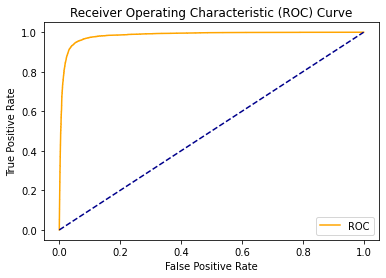

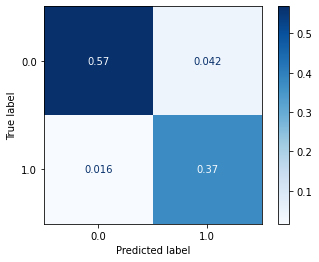

In [33]:
# Use the Catboost

import catboost as cb
params_cb ={'iterations': 50,
            'max_depth': 16}

model_cb = cb.CatBoostClassifier(**params_cb)
model_cb, accuracy_cb, roc_auc_cb, coh_kap_cb, tt_cb = run_model(model_cb, X_train, y_train, X_test, y_test, verbose=False)